In [6]:
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook
from __future__ import print_function

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer
from chipwhisperer.capture.auxiliary.ResetCW1173Read import ResetCW1173
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simple_pass_cpa'))
hex_file = os.path.join(firmware_dir, r'simple_pass_cpa-CW303.hex')

In [7]:
# Notebook settings
%matplotlib notebook

In [8]:
#%%bash -s "$firmware_dir"
#cd "$1"
#make PLATFORM=CW303

In [9]:
scope = cw.scope()
target = cw.target(scope)

In [10]:
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3195 bytes


In [11]:
scope.gain.gain = 45
scope.gain.mode = 'low'
scope.adc.samples = 700
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.adc.timeout = 5
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"
delay_ms = 1
Resetter = ResetCW1173(pin='pdic', delay_ms=delay_ms)

In [12]:
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def runone(x,y):
    Resetter.reset(scope)
    scope.arm()
    target.getConnection().hardware_write(x)
    target.getConnection().hardware_write(y)
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    scope.capture()
    return scope.getLastTrace()
def getbit(b,i):
    if((ord(b)&(1<<i))!=0):
        return 1
    else:
        return 0
def flipbit(s,byte,bit):
    return s[:byte]+chr(ord(s[byte])^(1<<bit))+s[byte+1:]
def hexdump(x):
    return ":".join("{:02x}".format(ord(c)) for c in x)
def getexpected(byte,bit):
    v = b'verysafe'
    return getbit(v[byte],bit)
HW = [bin(n).count("1") for n in range(0,256)]
def HD(a,b):
    return HW[a^b]

<IPython.core.display.Javascript object>


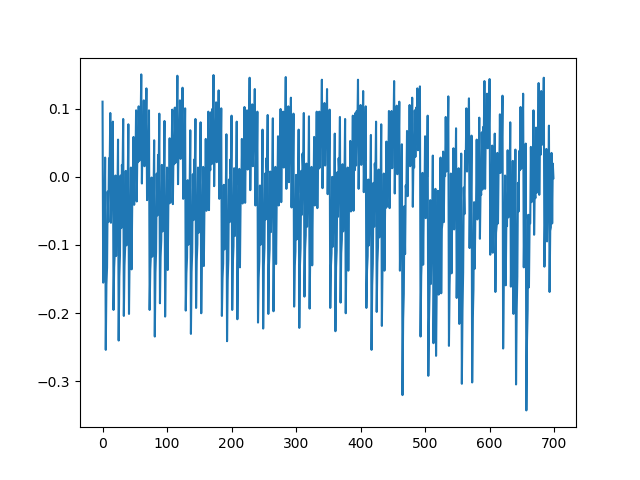

In [13]:
plot((runone(b'aaaaaaaa',b'aaaaaaaa'),))

In [34]:
secr = b'feedcafe'
ntrc = 70

In [35]:
trcs = []
inps = []
for i in tnrange(ntrc, desc='Getting traces'):
    x = os.urandom(8)
    trcs.append(runone(secr,x))
    inps.append(x)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdHZXR0aW5nIHRyYWNlcycsIG1heD03MCwgc3R5bGU9UHJvZ3Jlc3NTdHlsZShkZXNjcmlwdGlvbl93aWTigKY=


<IPython.core.display.Javascript object>


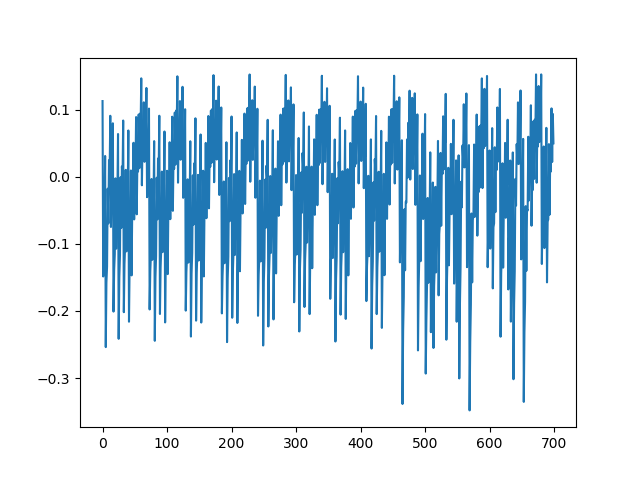

In [36]:
avg = sum(trcs)/len(trcs)
plot((avg,))

In [37]:
#plot((trcs[0],))
#plot((np.correlate(trcs[0], trcs[0], mode='full'),))
pattern = avg[20:60]
pattern_length = len(pattern)
results = []
for i in range (len(trcs[0]) - pattern_length):
    sample = avg[i:i+pattern_length]
    x = sum(abs(abs(sample) - abs(pattern)))
    results.append(x)

<IPython.core.display.Javascript object>


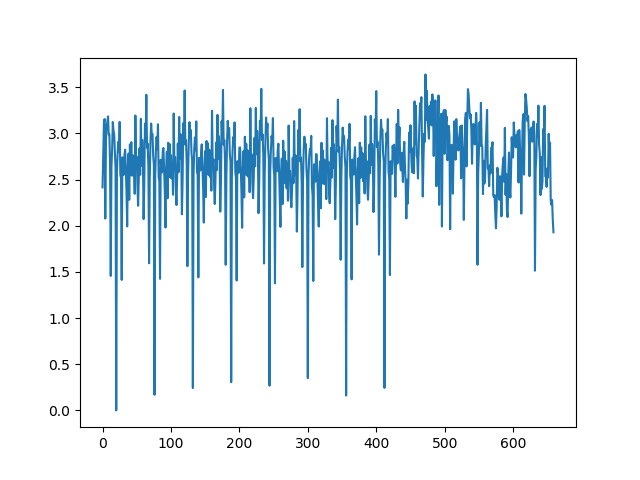

[ 20  76 132 188 244 300 356 412]
[56, 56, 56, 56, 56, 56, 56]


In [38]:
results = np.array(results)
plot((results,))
points = np.where(results<1.0)[0]
print(points)

diffs = []

for i in range(len(points)-1):
    diffs.append(points[i+1]-points[i])
print(diffs)

In [39]:
length = 56
length_all_iterations = 56*8

for i in range(30):
    sample = avg[i:i+length_all_iterations]
    pattern = sample[:56]
    corrs = []
    for j in range(7):
        sample2 = avg[(j+1)*56:(j+2)*56]
        corrs.append(np.corrcoef(sample2, pattern)[0,1])
    print(i)
    print(corrs)
    print(" ")

0
[0.7779816080955783, 0.7674647525534579, 0.7708976098360452, 0.7680160168144677, 0.7796532302974366, 0.7741260923108361, 0.77468539803068]
 
1
[-0.03874285616296857, -0.04017371844111334, -0.027471817075491695, -0.03150279736608286, -0.04384024801597799, -0.04511291457360153, -0.02990797927342761]
 
2
[0.07266892723935947, 0.07376801466386332, 0.0803542492398339, 0.07497797088295327, 0.07354416150934096, 0.06798680781430132, 0.07226718287022149]
 
3
[-0.2386931386667541, -0.2308462239885071, -0.2220373421513481, -0.23013794084661063, -0.24955416802403024, -0.2467750949454414, -0.2380377530047899]
 
4
[0.36653400844273737, 0.37666078223071364, 0.36845819266874025, 0.36438278592666556, 0.35698072402171005, 0.3606219937216821, 0.3476655035016278]
 
5
[-0.2423260237936579, -0.22986713627724237, -0.22485684417408053, -0.22849448090490346, -0.25430790297073236, -0.24876061232112012, -0.24390407188450336]
 
6
[0.05125553190156568, 0.05836587072530047, 0.06427604972032865, 0.0611101492440690

In [40]:
plot((avg[8:8+length_all_iterations],))
plot((avg[8:8+56],))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


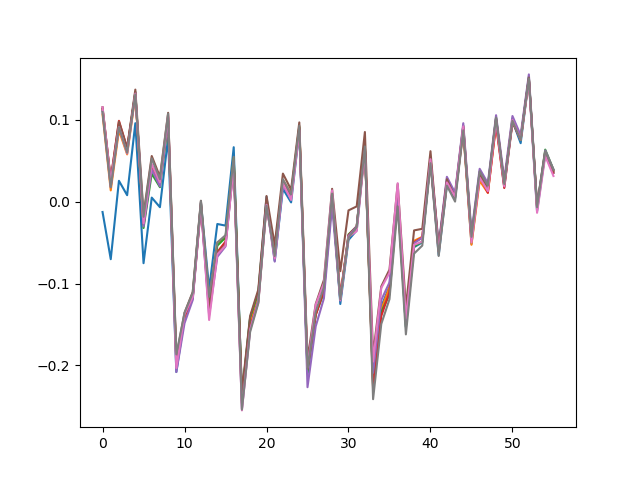

In [41]:
def getiteration(x,i):
    start  = 8
    length = 56
    offs   = length
    return x[start+i*offs:start+i*offs+length]
ts=[]
for i in range(8):
    ts.append(getiteration(trcs[i],i))
plot(ts)

In [42]:
def guessbyte(trcs,avg,byte):
    ntrc = len(trcs)
    ltrc = len(getiteration(trcs[0],byte))
    rss = []
    for guess in range(256):
        hs = []
        for i in range(len(trcs)):
            c = ord(inps[i][byte])
            d = HW[guess^c]
            hs.append(d)
        meanh = np.mean(hs, dtype=np.float64)
        covht = np.zeros(ltrc)
        varh  = np.zeros(ltrc)
        vart  = np.zeros(ltrc)
        for i in range(ntrc):
            hdiff = hs[i] - meanh
            tdiff = getiteration(trcs[i],byte) - getiteration(avg,byte)
            covht += hdiff*tdiff
            varh  += hdiff**2
            vart  += tdiff**2
        rs = covht / np.sqrt(varh * vart)
        np.nan_to_num(rs, copy=False)
        rss.append(max(-rs))
    sgs = sorted(range(len(rss)), key=lambda k: rss[k], reverse=True)
    print('Best guesses for byte %d:'%(byte))
    for i in range(4):
        k = sgs[i]
        print('  %s\t%s\t+%f'%(hexdump(chr(k)),chr(k),rss[k]))
    return sgs[0]

In [43]:
for i in range(8):
    guessbyte(trcs,avg,i)

Best guesses for byte 0:
  66	f	+0.888461
  20	 	+0.863924
  00	 	+0.754448
  02		+0.740557
Best guesses for byte 1:
  65	e	+0.863597
  25	%	+0.703183
  64	d	+0.680325
  00	 	+0.677164
Best guesses for byte 2:
  65	e	+0.729099
  64	d	+0.654668
  84	�	+0.610740
  66	f	+0.601324
Best guesses for byte 3:
  64	d	+0.871467
  60	`	+0.781315
  e4	�	+0.766901
  6c	l	+0.687701
Best guesses for byte 4:
  63	c	+0.812479
  62	b	+0.724454
  23	#	+0.666883
  43	C	+0.656016
Best guesses for byte 5:
  61	a	+0.874241
  60	`	+0.673295
  69	i	+0.636693
  63	c	+0.615382
Best guesses for byte 6:
  66	f	+0.728711
  26	&	+0.650936
  80	�	+0.628414
  64	d	+0.623145
Best guesses for byte 7:
  65	e	+0.939646
  64	d	+0.806841
  25	%	+0.777839
  61	a	+0.777142


In [44]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()